In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
data = pd.read_csv('C:/Users/karagiag/Downloads/GE-FF.csv',parse_dates = True, index_col=0)

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14013 entries, 1962-01-03 to 2017-08-31
Data columns (total 5 columns):
ret       14013 non-null float64
Mkt-RF    14013 non-null float64
SMB       14013 non-null float64
HML       14013 non-null float64
RF        14013 non-null float64
dtypes: float64(5)
memory usage: 656.9 KB


In [58]:
y=data['ret']

In [59]:
X = data.drop(['ret', 'RF'],axis=1)

In [61]:
#When you have training and test data, fit a scaler on training data and use this scaler on test data. 
#Here, scale only features (independent variables), not target variable y.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

In [ ]:
#Use sklearn.neural_nework.MLPRegressor to do a 5-fold cross validation using sklearn's KFold.
#The cross validation must be performed on the training data. Use following parameter settings
#for MLPRegressor: activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
#batch_size=40, learning_rate_init = 0.001
#Now, consider two different settings for the number of hidden units:
#(a) hidden_layer_sizes = (2,) (b) hidden_layer_sizes = (15,)
#Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation 
#for each model: (a) and (b)

In [139]:
#Cross Validation
#http://scikit-learn.org/stable/modules/cross_validation.html
param_hidden_layers = [(350,),(1750,)]
n_folds = 5
kf = KFold(n_splits=n_folds)

In [143]:
for param_hidden in param_hidden_layers:
    aRMSE = 0
    for train_idx, test_idx in kf.split(X_train):
        regMLP = MLPRegressor(activation = 'relu',
                              solver = 'sgd',
                              learning_rate='constant',
                              random_state=42,
                              batch_size=100,
                              learning_rate_init = 0.001,
                              hidden_layer_sizes = param_hidden)
        stdScaler = StandardScaler()
        xTrain = stdScaler.fit_transform(X_train.iloc[train_idx,:])
        yTrain = y_train.iloc[train_idx]
            
        regMLP.fit(xTrain,yTrain)
        aRMSE += np.sqrt(mean_squared_error(y_train.iloc[test_idx],
                                            regMLP.predict(stdScaler.transform(X_train.iloc[test_idx,:]))))/n_folds
    print '<hidden layer: {}>\n Average RMSE (CV): {}\n'.format(param_hidden,aRMSE)

<hidden layer: (350,)>
 Average RMSE (CV): 0.0265233999204

<hidden layer: (1750,)>
 Average RMSE (CV): 0.022438167924



In [144]:
#Now, using the same parameters used in part 1), train MLPRegressor models on whole training 
#data and report RMSE score for both Train and Test set (Again, use StandardScaler). 
#Which model works better, (a) or (b)? 
#Briefly analyze the result in terms of the number of hidden units

In [148]:
RMSE_train_test = {}
regMLPs = {}
r2_scores = {}
for param_hidden in param_hidden_layers:
    regMLP = MLPRegressor(activation = 'tanh',
                          solver = 'sgd',
                          learning_rate='adaptive',
                          random_state=42,
                          batch_size=40,
                          learning_rate_init = 0.001,
                          hidden_layer_sizes = param_hidden)
    stdScaler = StandardScaler()
    xTrain = stdScaler.fit_transform(X_train)
    regMLP.fit(xTrain,y_train)
    RMSE_train_test[param_hidden] = [np.sqrt(mean_squared_error(y_train,regMLP.predict(xTrain))),
                                     np.sqrt(mean_squared_error(y_test,regMLP.predict(stdScaler.transform(X_test))))]
    r2_scores[param_hidden] = [r2_score(y_train,regMLP.predict(xTrain)),
                               r2_score(y_test,regMLP.predict(stdScaler.transform(X_test)))]
    regMLPs[param_hidden] = regMLP
    
    print '<hidden layer: {}>\n RMSE (Train) = {}, RMSE (Test) = {}\n r2_score (Train) = {}, r2_score(Test)={}\n'.format(param_hidden,
                                                                                                                         RMSE_train_test[param_hidden][0],
                                                                                                                         RMSE_train_test[param_hidden][1],
                                                                                                                         r2_scores[param_hidden][0],
                                                                                                                         r2_scores[param_hidden][1])

<hidden layer: (350,)>
 RMSE (Train) = 0.0193378011582, RMSE (Test) = 0.018895771653
 r2_score (Train) = 0.0764289706201, r2_score(Test)=0.151649117988

<hidden layer: (1750,)>
 RMSE (Train) = 0.0164503480336, RMSE (Test) = 0.0164412700888
 r2_score (Train) = 0.331646383912, r2_score(Test)=0.357730972715



In [115]:
#MLP regressor with 15 hidden units performed better than the one with only 2 hidden units. 
#Increasing number of hidden units is directly related to the complexity of model, 
#and this regression problem was better fit by the more complex model.
#(Note: Increasing the number of hidden units and hidden layers will make model more complex. 
#However, excessive number of hidden units and hidden layers can also hurt your model 
#by leading it to overfit.

In [116]:
#MLPRegressor has a built-in attribute loss_curve_ which returns the loss at each epoch 
#(misleadingly referred to as "iteration" in scikit documentation, though they use epoch 
#in the actual code!). For example, if your model is named as my_model you can call it as 
#my_model.loss_curve_ (example). Plot two curves for model (a) and (b) in one figure, 
#where X-axis is epoch number and Y-axis is squared root of loss_curve_ value.

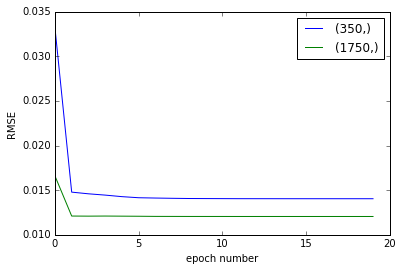

In [149]:
for param_hidden in param_hidden_layers:
    regMLP = regMLPs[param_hidden]
    plt.plot(np.sqrt(regMLP.loss_curve_), label = str(param_hidden))

plt.legend()
plt.ylabel('RMSE')
plt.xlabel('epoch number')

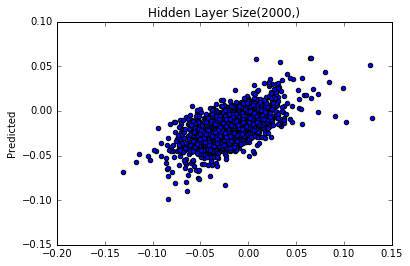

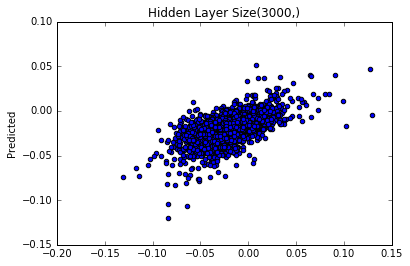

In [138]:
for param_hidden in param_hidden_layers:
    y_hat = regMLPs[param_hidden].predict(stdScaler.transform(X_test))
 
    fig, ax=plt.subplots()
    plt.scatter(y_test,y_hat)
    plt.ylabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Hidden Layer Size{}'.format(param_hidden))
    #plt.ylim(y_test.min(),y_test.max())
    #plt.xlim(y_test.min(),y_test.max())
    #plt.plot([-.15,.15],[-.15,.15], 'k--')